# **Deep Learning**
## Blink detection

## 1. PRIMERA APROXIMACIÓN

Entrenar una CNN desde cero para la detección de parpadeo en una serie de imágenes.

### 1.1. Importar librerías
Lo primero que vamos a hacer es cargar las librería necesarias: Numpy. Matplotlib, TensorFlow, Keras, Google Colab, Sklearn y Pandas .


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, BatchNormalization, ReLU

from google.colab import drive
from sklearn.model_selection import train_test_split

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1321254335982589720
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2892052887942070498
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Definimos la función generadora de las imágenes para cada ojo y etiquetas correspondientes:

In [ ]:
# Generador custom que devuelve las dos imagenes de ojos y el label del parpadeo
def generator(dataframe):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                   directory = imgs_path,
                                                   target_size =(img_width, img_height),
                                                   x_col=left_eye_col,
                                                   y_col=y_col,
                                                   class_mode="binary",
                                                   seed=seed,
                                                   batch_size=batch_size)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                    directory = imgs_path,
                                                    target_size =(img_width, img_height),
                                                    x_col=right_eye_col,
                                                    y_col=y_col,
                                                    class_mode="binary",
                                                    seed=seed,
                                                    batch_size=batch_size)
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

## 1.2. Lectura del dataset
El siguiente paso consiste en la lectura del dataset y la construcción de un dataframe con las rutas a cada una de las imágenes y sus etiquetas asociadas.

Se monta el Drive para acceder a nuestro conjunto de datos y descomprimir el fichero zip:

In [ ]:
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/RT-BENE.zip' >> /dev/null

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


A contiunación, leemos los datos y construimos el dataframe:

In [ ]:
data_path = 'RT-BENE/'
imgs_path = data_path + 'images/'
labels_path = data_path + 'blinks.csv'

seed = 100

train_data = pd.read_csv(labels_path, dtype=str) # Reading as string so the generator does not complain about the label (numeric being considered as an index)

datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             horizontal_flip=True,
                             brightness_range=[0.9,1])
                             #zoom_range=20,
                             #width_shift_range=20)

En las siguientes celdas, se realizan una serie de comprobaciones relativas a balanceo de clases:

In [ ]:
print("Initiially, we have the following instances per class: ")
print(train_data['blink'].value_counts())

0    102793
1      4557
Name: blink, dtype: int64


Debido al desbalanceo que hay, se opta por separar el dataframe en dos, uno por cada clase, para procesarlos de manera independiente:

In [ ]:
blink = train_data.loc[train_data['blink']=='1'].reset_index()
no_blink = train_data.loc[train_data['blink']=='0'].reset_index()

In [ ]:
print("Blink instances: " + blink.shape[0])
print("No blink instances: " + no_blink.shape[0])

4557


Este desbalanceo se va a intentar combatir con un sobremuestreo de la clase minortaria y la introducción de un data augmentation en el ImageDaraGenerator definido anteriormente:

In [ ]:
print(sorted(blink['video'].value_counts(), reverse=True))

[931, 789, 692, 459, 353, 295, 215, 167, 149, 130, 128, 110, 45, 42, 29, 23]


In [ ]:
conteo = blink['video'].value_counts()

In [ ]:
print("Blink instances per video: ")
print(conteo)

0     931
2     789
11    692
8     459
10    353
13    295
14    215
3     167
7     149
4     130
1     128
5     110
9      45
16     42
15     29
12     23
Name: video, dtype: int64


In [ ]:
print(blink['video'].unique().tolist())

['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']


In [ ]:
print("No blink instances per video: ")
print(no_blink['video'].value_counts())

10    16206
11    12125
0     11934
13     9291
1      8543
2      7913
8      5649
5      5245
14     5156
4      4620
16     4507
9      4165
3      3038
15     1781
7      1708
12      912
Name: video, dtype: int64


El sobremuestreo se va a realizar de tal manera que se van a replicar las rutas de las imágenes a la clase minoritaria, y posteriormente se transformarán con el ImageDataGenerator de tal manera que los ejemplos son diferentes aunque se elija un mismo fichero de imagen.

Además, esta replicación se va a hacer por vídeo, de tal manera que tengamos el mismo número de ejemplo de parpadeo y no parpadeo también por vídeo. Esto se ha decidido ya que al revisar el dataset, se ha visto que de un vídeo a otro puede cambiar el brillo, la orientación y la persona, por lo que de esta manera se equilibran también los ejemplos para cada una de las características.


In [ ]:
def replicate_dataframe(dataframe, target_size):
    num_replications = target_size // len(dataframe) + 1
    replicated_dataframe = pd.concat([dataframe] * num_replications, ignore_index=True)
    return replicated_dataframe[:target_size]


In [ ]:
def balance_classes(new_blink, blink, no_blink):
  blink_count = blink['video'].value_counts()
  no_blink_count = no_blink['video'].value_counts()

  blink_videos = blink['video'].unique().tolist()
  no_blink_videos = no_blink['video'].unique().tolist()

  for video_id in blink_videos:
    no_blink_value = no_blink_count[video_id]

    df = replicate_dataframe(blink[blink['video']==video_id],no_blink_value-blink_count[video_id])
    new_blink = pd.concat([new_blink, df], ignore_index=True)
  
  return new_blink

In [ ]:
new_blink = blink.copy()
blink_augmented = balance_classes(new_blink, blink, no_blink)
blink_augmented = blink_augmented.reset_index()

Ahora, como se puede ver, tenemos el mismo número de ejemplos de parpadeo y no parpadeo, no solamente en todo el dataset, sino también por vídeo.

In [ ]:
print(blink_augmented.shape[0])

102793


In [ ]:
blink_augmented.iloc[:-10]

,level_0,index,blink_id,left_eye,right_eye,video,blink
0,0,160,160,0_left_000161_rgb.png,0_right_000161_rgb.png,0,1
1,1,161,161,0_left_000162_rgb.png,0_right_000162_rgb.png,0,1
2,2,162,162,0_left_000163_rgb.png,0_right_000163_rgb.png,0,1
3,3,163,163,0_left_000164_rgb.png,0_right_000164_rgb.png,0,1
4,4,164,164,0_left_000165_rgb.png,0_right_000165_rgb.png,0,1
...,...,...,...,...,...,...,...
102778,102778,106177,106177,16_left_007157_rgb.png,16_right_007157_rgb.png,16,1
102779,102779,106178,106178,16_left_007158_rgb.png,16_right_007158_rgb.png,16,1
102780,102780,102980,102980,16_left_000182_rgb.png,16_right_000182_rgb.png,16,1
102781,102781,104178,104178,16_left_003462_rgb.png,16_right_003462_rgb.png,16,1


In [ ]:
print(blink_augmented['video'].value_counts())

10    16206
11    12125
0     11934
13     9291
1      8543
2      7913
8      5649
5      5245
14     5156
4      4620
16     4507
9      4165
3      3038
15     1781
7      1708
12      912
Name: video, dtype: int64


In [ ]:
print(no_blink['video'].value_counts())

10    16206
11    12125
0     11934
13     9291
1      8543
2      7913
8      5649
5      5245
14     5156
4      4620
16     4507
9      4165
3      3038
15     1781
7      1708
12      912
Name: video, dtype: int64


Finalmente, juntamos todos los ejemplos de parpadeo y no parpadeo, confirmando nuestro dataset aumentado:

In [ ]:
train_data_aug=pd.concat([blink_augmented,no_blink], axis=0, ignore_index=True)
print("Total number of intstances in the augmented dataset: " + train_data_aug.shape[0])

205586


In [ ]:
print(train_data_aug['blink'].value_counts())

1    102793
0    102793
Name: blink, dtype: int64


In [ ]:
train_data_aug = train_data_aug[::2]

In [ ]:
print(train_data_aug['blink'].value_counts())

1    51397
0    51396
Name: blink, dtype: int64


## 1.3. Entrenamiento del modelo

A continuación, se van a separar los datos enconjuntos de entrenamiento, validación y test para entrenar a la red.

In [ ]:
train_data, test_data = train_test_split(train_data_aug, test_size=0.3, random_state=seed, stratify=train_data_aug['blink'])
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=test_data['blink'])

train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

batch_size = 256
img_width = 60
img_height = 36

train_generator = generator(train_data)
dev_generator = generator(dev_data)
test_generator = generator(test_data)

Tras separar los datos, comprobamos que efectivamente, el equilibrio entre clases se mantiene en buena medida:

In [ ]:
print("Total number of training instances per class: ")
print(train_data['blink'].value_counts())

1    35978
0    35977
Name: blink, dtype: int64


In [ ]:
print("Total number of training blinks per video:")
print(train_data[train_data['blink']=='1']['video'].value_counts())

print("\nTotal number of training no blink per video: ")
print(train_data[train_data['blink']=='0']['video'].value_counts())

10    5706
11    4303
0     4177
13    3228
1     2955
2     2758
8     1966
14    1786
5     1783
4     1630
16    1574
9     1489
3     1076
15     627
7      604
12     316
Name: video, dtype: int64


Se visualizan algunas de las imágenes de entrenamiento junto con sus etiquetas:


Found 143910 validated image filenames belonging to 2 classes.
Found 143910 validated image filenames belonging to 2 classes.
0.0
0.0
1.0


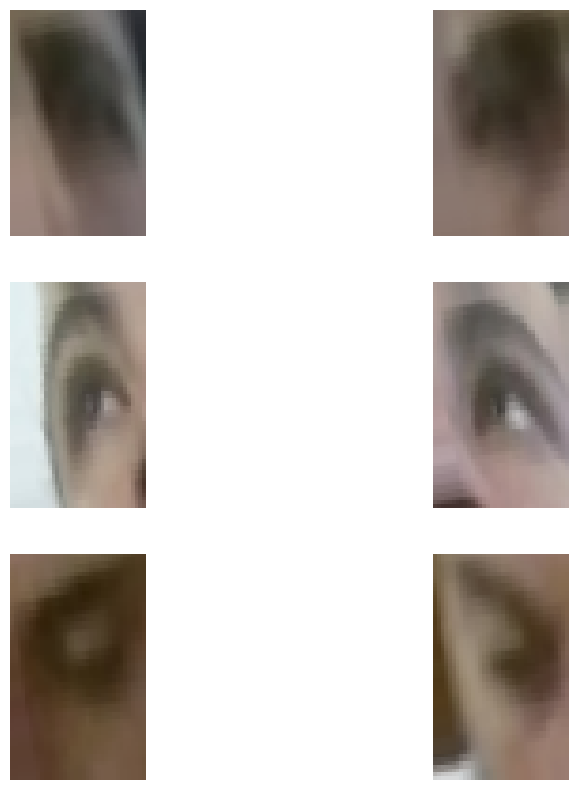

In [ ]:
aug_iter = generator(train_data)
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))

for i in range(3):
  eye = next(aug_iter)
  left_eye_image = eye[0][0][i]
  right_eye_image = eye[0][1][i]

  ax[i,0].imshow(right_eye_image)
  ax[i,1].imshow(left_eye_image)
  ax[i,0].axis('off')
  ax[i,1].axis('off')

  ax[i,0].set_title(f'Data augmented left eye (instance: {i}, label: {eye[1][i]}')
  ax[i,1].set_title(f'Data augmented right eye (instance: {i}, label: {eye[1][i]}')

El entrenamiento de la red se va a realizar utilizando el F1-Score como medida de evaluación. para ello, es necesario instalar el módulo 'tfa' de los 'tensorflow_addons'

In [ ]:
!pip3 install --upgrade pip
!pip3 install tfa-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_addons as tfa

def f1_score(y_true,y_pred):
  metric = tfa.metrics.F1Score(num_classes=1, threshold=0.25)

  metric.update_state(y_true, y_pred)
  result = metric.result()

  return result.numpy()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Definimos el modelo de la red neuronal convolucional:
- Dos capas de entrada (ojo izquierdo y derecho)
- Capa de concatenación para juntar en una sola las dos imágenes. La concatenación se hace en la primera dimensión, es decir, se concatenan horizontalmente.
- Dos capas convolucionales (16@3x3 y 32@3x3) con una regularización Dropout al 50%.
- Una capa plana para juntar todas las careacterísticas latentes extraídas por la red
- Una capa densa, que procesará de menra conjunta las características latentes.
- Una capa de salida con una única neurona y activación sigmoide (caso típico de clasificación binaria sin utilizar one-hot encoding).

In [ ]:
input_shape = (60, 36, 3)
# Declaramos dos capas de Input
input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_layer= Concatenate(name='concat', axis=1)([input_1, input_2])

conv_1 = Conv2D(16, 3, name='conv1', activation='relu', padding='same', input_shape=(img_width,img_height,3))(concat_layer)
#bn_1_1 = BatchNormalization()(conv_1_1)
#re_1_1 = ReLU()(bn_1_1)
dr_1 = Dropout(0.5)(conv_1)
max_1 = MaxPooling2D(name='max1', pool_size=2, strides=2)(dr_1)

conv_2 = Conv2D(16, 3, name='conv2', activation='relu', padding='same')(max_1)
dr_2 = Dropout(0.5)(conv_2)
max_2 = MaxPooling2D(name='max2', pool_size=3, strides=3)(dr_2)

#conv_3 = Conv2D(64, 3, name='conv3', activation='relu', padding='valid')(max_2)
#dr_3 = Dropout(0.5)(conv_3)
#max_3 = MaxPooling2D(name='max3', pool_size=3, strides=3)(dr_3)

flat_layer_1 = Flatten(name='flat')(max_2)

dense_1 = Dense(16, name='dense1', activation='relu')(flat_layer_1)
#dense_2 = Dense(150, name='dense2', activation='relu')(dense_1)
predictions = Dense(1, name='output', activation='sigmoid')(dense_1)

# Creamos el modelo final y lo compilamos
model = Model(inputs=[input_1, input_2], outputs=[predictions], name='blink_detector')
# Compilamos el modelo
model.compile(loss='binary_crossentropy',                # función de pérdida para problemas de clasificación binaria
              optimizer=optimizers.Adam(learning_rate=1e-4),  # optimizador Adam
              metrics=[tfa.metrics.F1Score(name='f1_score',num_classes=1,threshold=0.5,average='macro'),'accuracy'])

In [ ]:
model.summary()

Model: "blink_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_eye (InputLayer)          [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 right_eye (InputLayer)         [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concat (Concatenate)           (None, 120, 36, 3)   0           ['left_eye[0][0]',               
                                                                  'right_eye[0][0]']              
                                                                                                  
 conv1 (Conv2D)                 (None, 120, 36, 16)  448         ['concat[0][0]']    

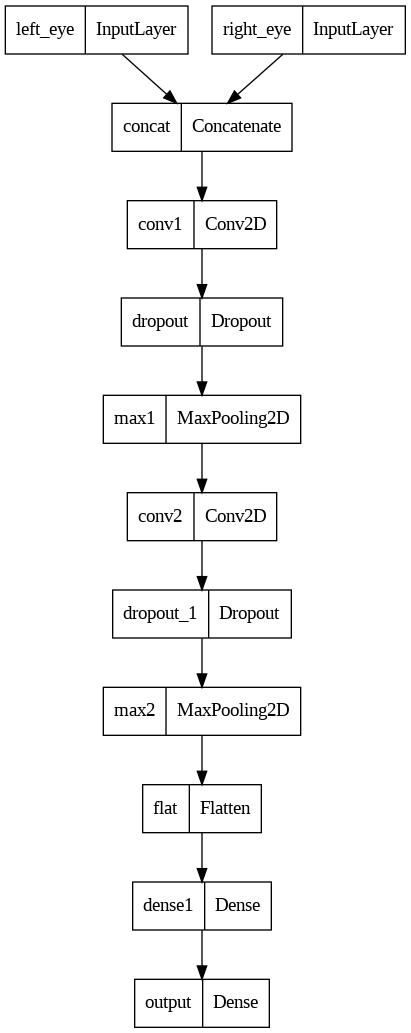

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

In [ ]:
## Función para mostrar la evolución de la pérdida durante el entrenamiento
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('binary_crossentropy')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])

Como medida para evitar el overfitting, se aplica un early stopping al entrenamiento de la red. Este early stopping va a tomar como medida de referencia la pérdida en valdiación, y en cuanto detecte que esta no se mejora durante 5 épocas seguidas, parará el entrenamiento.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

A continuación, se entrena el modelo y se grafica su evolución:

In [ ]:
# Entrenamos el modelo con los datos preparados en el punto 2
history = model.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size,
                    callbacks=[early_stopping])

Found 71955 validated image filenames belonging to 2 classes.
Found 71955 validated image filenames belonging to 2 classes.
Epoch 1/20
282/281 [==============================] - ETA: 0s - loss: 0.6500 - f1_score: 0.5959 - accuracy: 0.6206Found 15419 validated image filenames belonging to 2 classes.
Found 15419 validated image filenames belonging to 2 classes.
281/281 [==============================] - 334s 1s/step - loss: 0.6500 - f1_score: 0.5959 - accuracy: 0.6206 - val_loss: 0.6763 - val_f1_score: 0.6915 - val_accuracy: 0.5844
Epoch 2/20
281/281 [==============================] - 264s 941ms/step - loss: 0.6026 - f1_score: 0.6819 - accuracy: 0.6818 - val_loss: 0.6304 - val_f1_score: 0.7833 - val_accuracy: 0.7512
Epoch 3/20
281/281 [==============================] - 261s 933ms/step - loss: 0.5031 - f1_score: 0.7716 - accuracy: 0.7684 - val_loss: 0.5747 - val_f1_score: 0.8255 - val_accuracy: 0.8015
Epoch 4/20
281/281 [==============================] - 257s 916ms/step - loss: 0.4355 - f

In [ ]:
plot_history(history)

Finalmente, se evalúa el modelo entrenado:

In [ ]:
# Por último, podemos evaluar el modelo en el conjunto de test
test_loss, test_f1, test_accuracy = model.evaluate(test_generator,
                                     batch_size=batch_size,
                                     steps=len(test_data)/batch_size,
                                     verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test F1-Score: {test_f1}")
print(f"Test accuracy: {test_accuracy}")

Found 15419 validated image filenames belonging to 2 classes.
Found 15419 validated image filenames belonging to 2 classes.
60/60 [==============================] - 47s 785ms/step - loss: 0.3582 - f1_score: 0.8990 - accuracy: 0.8988
test_loss: 0.3582, test_f1: 0.8990, test_Accuracy: 0.8988




---



## 2. SEGUNDA APROXIMACIÓN - TRANSFER LEARNING

En esta ocasión, con los mismos datos que antes, se va utilizar una red pre-entrenada, que se adaptará con una capa de entrada otras a la salida.

Solamente se entrenarán estas capas de salida durante la fase de entrenamiento, quedándose los pesos de la red original sin modificar.

In [ ]:
# Cargamos el modelo InceptionV3 pre-entrenado con ImageNet
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width*2,img_height,3))

# En el modelo base, hacemos que todas sus capas sean no entrenables
for layer in base_model.layers:
    layer.trainable = False

# Añadimos las dos capas de entrada y la de concatenación, para adapatarlas al modelo base
input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_transfer = Concatenate(name='concat', axis=1)([input_1, input_2])
new_base = base_model(concat_transfer)

# Añadimos nuevas capas al final para adaptar el modelo a nuestro problema
x = new_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_transfer = Dense(1, activation='sigmoid')(x) 

# Creamos el modelo final y lo compilamos
model_transfer = Model(inputs=[input_1, input_2], outputs=[predictions_transfer], name='blink_detector_transfer')

model_transfer.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=[tfa.metrics.F1Score(name='f1_score',num_classes=1,threshold=0.5,average='macro'),'accuracy'])

In [ ]:
model_transfer.summary()

In [ ]:
keras.utils.plot_model(model_transfer, to_file='model_transfer.png')

In [ ]:
# Entrenamos el nuevo modelo
history_transfer = model_transfer.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size,
                    callbacks=[early_stopping])

In [ ]:
# Mostramos la evolución de su entrenamiento
plot_history(history_transfer)

In [ ]:
# Y finalmente, evaluamos el modelo en el conjunto de test
print("\n")
test_loss_transfer, test_f1_transfer, test_accuracy_transfer = model_transfer.evaluate(test_generator,
                                                                                       steps=len(test_data)/batch_size,
                                                                                       verbose=1)
print(f"Test loss (transfer learning): {test_loss_transfer}")
print(f"Test F1-Score (transfer learning): {test_f1_transfer}")
print(f"Test accuracy (transfer learning): {test_accuracy_transfer}")